In [1]:
from utils import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [3]:
import xgboost as xgb

In [4]:
df_train = pd.read_csv('./data/train_10M.csv') 
df_train['pickup_datetime'] = df_train['pickup_datetime'].str.slice(0, 16)
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

In [5]:
df_train = add_features(df_train)
df_train = clean_df(df_train)
df_train = df_train.reset_index()
df_train = df_train.drop(['index'], axis=1)
df_train = drop_date(df_train)

Old size: 10000000
New size: 9633165


In [6]:
cols = df_train.columns.tolist()
cols.remove('fare_amount')

X = df_train[cols]
y = df_train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [7]:
matrix_train = xgb.DMatrix(X_train,label=y_train)
matrix_test = xgb.DMatrix(X_test,label=y_test)

In [8]:
%%time

params = {
    'objective':'reg:squarederror',
    'eval_metric':'rmse',
    'silent': 0,
    'nthread': 8,
    'n_jobs': 8,
}

model = xgb.train(
    params=params,
    dtrain=matrix_train,
    num_boost_round=150,
    early_stopping_rounds=10,
    evals=[(matrix_test,'test')],
)

[23:15:57] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	test-rmse:10.4058
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:7.76893
[2]	test-rmse:6.06055
[3]	test-rmse:4.99436
[4]	test-rmse:4.36342
[5]	test-rmse:4.00534
[6]	test-rmse:3.80178
[7]	test-rmse:3.68776
[8]	test-rmse:3.6088
[9]	test-rmse:3.56806
[10]	test-rmse:3.53452
[11]	test-rmse:3.51262
[12]	test-rmse:3.49633
[13]	test-rmse:3.47695
[14]	test-rmse:3.4699
[15]	test-rmse:3.45309
[16]	test-rmse:3.44286
[17]	test-rmse:3.43598
[18]	test-rmse:3.42818
[19]	test-rmse:3.42157
[20]	test-rmse:3.41423
[21]	test-rmse:3.40716
[22]	test-rmse:3.39921
[23]	test-rmse:3.39493
[24]	test-rmse:3.38899
[25]	test-rmse:3.38728
[26]	test-rmse:3.37693
[27]	test-rmse:3.36928
[28]	test-rmse:3.36629
[29]	test-rmse:3.36372
[30]	test-rmse:3.36022
[31]	test-rmse:3.35338
[32]	test-rmse:3

In [9]:
y_pred = model.predict(matrix_test, ntree_limit=model.best_ntree_limit)
print('RMSE:', math.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2 :', r2_score(y_test, y_pred))

RMSE: 3.206720274240715
R^2 : 0.8846701098336431


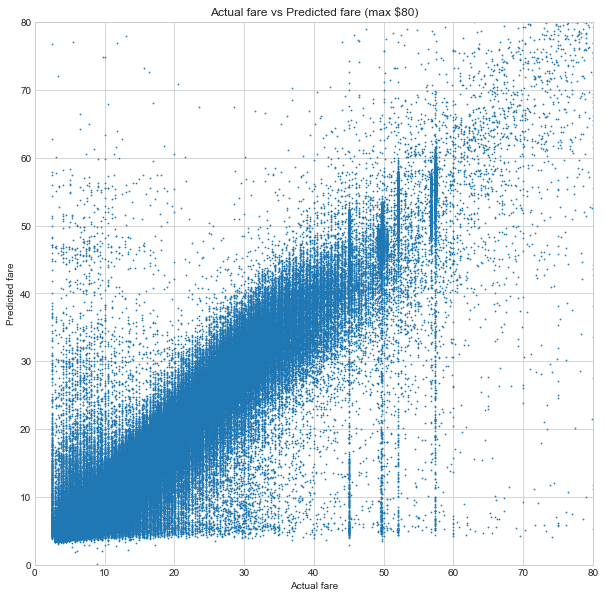

In [10]:
plot_predictions(y_test, y_pred)

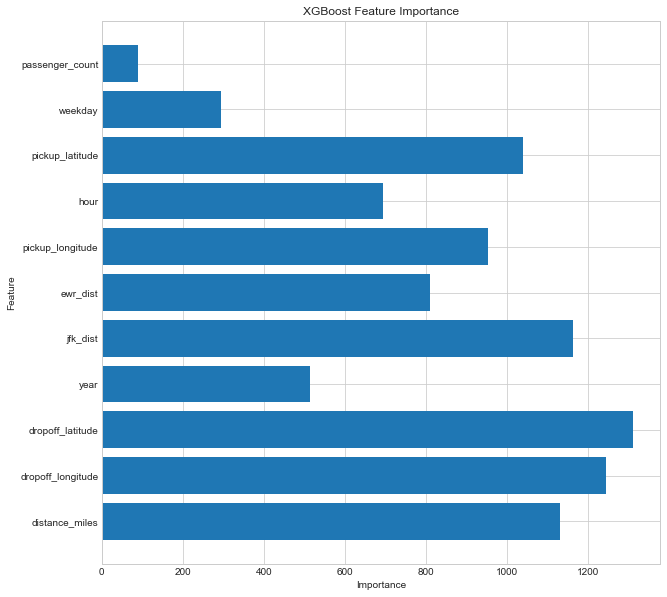

In [11]:
plt.figure(figsize=(10,10))
plt.barh(*zip(*model.get_fscore().items()))
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

---

# Creating the Kaggle submission file (prediction on official test set)

In [12]:
df_test = pd.read_csv('./data/test.csv') 
df_test['pickup_datetime'] = df_test['pickup_datetime'].str.slice(0, 16)
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

df_test = add_features(df_test)
df_test = drop_date(df_test)

df_test = df_test.drop(['key'], axis=1)

In [13]:
pred_test = model.predict(xgb.DMatrix(df_test), ntree_limit = model.best_ntree_limit)

In [14]:
df_test = pd.read_csv('./data/test.csv') 

submission = pd.DataFrame({
        "key": df_test['key'],
        "fare_amount": pred_test.round(2)
})

submission.to_csv('03_1_taxi_fare_submission_default.csv',index=False)